In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [3]:
name = 'Chewie'
date = '1007'
fold = 4
target_variable = 'vel'

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [5]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [6]:
data_path = './Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [7]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

In [8]:
force_df =  tidy_df.loc[tidy_df['epoch'] == 'AD']

We need to consider only the trials for which the monkey has already adapted to the perturbation.

In [9]:
ids_to_keep = force_df.id.unique()[50:]

The baseline subset has a total of 170 trials, whereas the perturbation one contains 201 trials, we can for now try to remove the first 50 trials from the perturbation subset.

In [10]:
force_df = force_df.loc[force_df.id.isin(ids_to_keep)]

## Get train-val-test split

In [11]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= target_variable, no_outliers = False, force_data = True)

Test trials  34
Val trials 27
We are testing the optimization method on fold  4


In [12]:
xx_train_force, yy_train_force, xx_val_force, yy_val_force,\
      xx_test_force, yy_test_force, info_train_force, info_val_force,\
          info_test_force,  list_mins_force, \
            list_maxs_force = get_dataset(force_df, fold, target_variable= target_variable, no_outliers = False, force_data = True)

Test trials  30
Val trials 24
We are testing the optimization method on fold  4


In [13]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all, \
    xx_test_all, yy_test_all, info_train_all, \
    info_val_all, info_test_all,  list_mins_all,\
          list_maxs_all = get_dataset(tidy_df,fold, target_variable= target_variable, no_outliers = False
                                      , force_data = True)

Test trials  66
Val trials 53
We are testing the optimization method on fold  4


In [14]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Force'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [15]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Model

In [16]:
def create_state_dict(param_names, param_values):
    s_d = {}
    for n,v in zip(param_names, param_values):
        s_d[n] = v
    return s_d

In [17]:
import torch
import torch.nn as nn

class RNN_Main_Model(nn.Module):
    def __init__(self, hnet_output, 
                 num_features = 124, 
                hidden_size= 3, 
                num_layers = 2, 
                out_dims = 6,
                dropout = 0.5,
                bias = True,
                LSTM_ = False):
        
        super(RNN_Main_Model, self).__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.hnet_output = hnet_output
        self.bias = bias
        self.out_features = out_dims
        self.LSTM_ = LSTM_

        self.dropout = nn.Dropout(p= dropout) #trial.suggest_float('dropout_1', 0.1, 0.9)

        # Define recurrent layer
        self.rnn = nn.RNN(self.num_features, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
        names_p = [name for name, _ in self.rnn.named_parameters()]
        self.hnet_output_dict = create_state_dict(names_p,hnet_output[2:] )

        # Define recurrent layer (LSTM)
        if self.LSTM_:
            self.rnn = nn.LSTM(self.num_features, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
            names_p = [name for name, _ in self.rnn.named_parameters()]
            self.hnet_output_dict = create_state_dict(names_p,hnet_output[2:] )      

        self.selu = nn.SELU()      

    def forward(self, x, hx=None):
        # Forward pass
        if hx is None:
            if self.LSTM_:
                h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1
                c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) *0.1 # Initialize cell state
                hx = (h0, c0)
            else:
                hx = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1
        
        # Perform RNN operation
        x, _  = torch.func.functional_call(self.rnn, self.hnet_output_dict, (x, hx))
        x = self.dropout(x)
        x = self.selu(x) 
        output =  F.linear(x, self.hnet_output[0], bias=self.hnet_output[1])
        
        return output.squeeze() 


#### Define a template model only to get automatically the model parameters shapes

In [18]:
num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

# Hyperparameters LSTM class (from force model without hnet)
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)


In [19]:
template_m = Causal_Simple_RNN(num_features=num_features, 
                    hidden_units= n_hidden_units, 
                    num_layers = num_layers, 
                    out_dims = num_dim_output, ).to(device)

In [20]:
param_shapes = [p.shape for p in list(template_m.parameters())]

In [21]:
param_shapes

[torch.Size([2, 300]),
 torch.Size([2]),
 torch.Size([300, 130]),
 torch.Size([300, 300]),
 torch.Size([300]),
 torch.Size([300])]

In [22]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[13], 
            num_cond_embs=num_conditions).to(device)

Created MLP Hypernet.
Hypernetwork with 1822961 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 16 conditional weights (16 internally maintained).


In [23]:
for param in hnet.parameters():
    param.requires_grad = True

In [24]:
w_test = hnet(cond_id = 0)

In [25]:
LSTM_ = False

In [26]:
model = RNN_Main_Model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers,out_dims=num_dim_output,  
                            dropout= dropout,  LSTM_ = LSTM_).to(device)

In [27]:
for param in model.parameters():
    param.requires_grad = False

In [28]:
def init_hnet(model):
    # Initialize weights
    for i, layer in enumerate(model.layer_weight_tensors[:-1]):
        nn.init.kaiming_uniform_(layer, mode='fan_in', nonlinearity='relu')
        if model.has_bias:
            nn.init.zeros_(model.layer_bias_vectors[i])
        

In [29]:
def reg_hnet(weights, alpha, l1_ratio):
    
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: MLP
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    l1_loss = 0
    l2_loss = 0

    # Accumulate L1 and L2 losses for weight matrices in the model
    

    weights_ =  [i for i in weights if len(i.shape)==2]

    for weight_tensor in weights_[:2]:
        l1_loss += torch.sum(torch.abs(weight_tensor))
        l2_loss += torch.sum(weight_tensor.pow(2))

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg

In [30]:
def train_hypernet(model, hnet,y_train_1, x_train_1,
                y_train_2,  x_train_2,
                y_val_1,  x_val_1,
                y_val_2,    x_val_2,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=15,
                batch_size_train = 25,
                batch_size_val = 25,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha_A = 1e-5,  
                alpha_B = 1e-5,        
                early_stop = 10,
                LSTM_ = LSTM_,
                chunks = False
                
                ):

    # Initialize the hypernetwork

    # --> this was only when using th models from hypnettorch
    """     if chunks:
         hnet.apply_chunked_hyperfan_init(mnet = model)
    else: 
         hnet.apply_hyperfan_init(mnet=model) """
    
    # Initialize the weights and biases of the hnet
    #init_hnet(hnet) #--> need to check what works better
    # Set up the optimizer with the specified learning rate
    optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset_1 = SequenceDataset(
    y_train_1,    x_train_1,    sequence_length=sequence_length_LSTM)

    train_dataset_2 = SequenceDataset(
    y_train_2,    x_train_2,    sequence_length=sequence_length_LSTM)

    val_dataset_1 = SequenceDataset(
    y_val_1,    x_val_1,    sequence_length=sequence_length_LSTM)

    val_dataset_2 = SequenceDataset(
    y_val_2,    x_val_2,    sequence_length=sequence_length_LSTM)

    loader_train_1 = data.DataLoader(train_dataset_1, batch_size=batch_size_train, shuffle=True)
    loader_train_2 = data.DataLoader(train_dataset_2, batch_size=batch_size_train, shuffle=True)

    loader_val_1 = data.DataLoader(val_dataset_1, batch_size=batch_size_val, shuffle=True)
    loader_val_2 = data.DataLoader(val_dataset_2, batch_size=batch_size_val, shuffle=True)

    # Initialize h0 and c0 outside the model
    if LSTM_ == True:

        h0 = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) * 0.1
        c0 = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) *0.1 # Initialize cell state
        hx = (h0, c0) 
    else:
        hx = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) * 0.1
    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loaders = zip(loader_train_1, loader_train_2)
            else:
                model.eval()
                loaders = zip(loader_val_1, loader_val_2)

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for data_1, data_2 in loaders:

                # Define data for this batch
                x_1 = data_1[0].to('cuda')
                y_1 = data_1[1].to('cuda')
                x_2 = data_2[0].to('cuda')
                y_2 = data_2[1].to('cuda')
               
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute FIRST loss.
                        W_1 = hnet(cond_id=0)
                        model = RNN_Main_Model(num_features= num_features, hnet_output = W_1,  hidden_size = n_hidden_units,
                            num_layers= num_layers, out_dims=num_dim_output,  
                            dropout= dropout, LSTM_ = LSTM_).to(device)
                                    
                        pred_1 = model(x_1, hx)
                        
                        loss_1 = huber_loss(pred_1, y_1, delta = delta)
                        
                        
                        # Compute SECOND loss.
                        W_2 = hnet(cond_id=1)
                        model = RNN_Main_Model(num_features= num_features, hnet_output = W_2,  hidden_size = n_hidden_units,
                            num_layers= num_layers, out_dims=num_dim_output,  
                            dropout= dropout, LSTM_ = LSTM_).to(device)        
                        pred_2 = model(x_2, hx)
                        loss_2 = huber_loss(pred_2, y_2, delta = delta)
                        
                        # Combine loss for 2 tasks
                        loss_t = loss_1 + loss_2    #only for printing

                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_2_reg = loss_2 + reg_hnet(W_2, alpha_B, l1_ratio)
                            loss_1_reg = loss_1 + reg_hnet(W_1,  alpha_A, l1_ratio)
                            # Combine loss for 2 tasks
                            loss_t_r = loss_1_reg + loss_2_reg

                        else:               
                            loss_t_r = loss_t 
                        
                    
                        # Compute gradients and perform an optimization step
                        loss_t_r.backward()
                        optimizer.step()


                else:
                    # just compute the loss in validation phase
                    # Compute FIRST loss.
                    W_1 = hnet(cond_id=0)
                    model = RNN_Main_Model(num_features= num_features, hnet_output = W_1,  hidden_size = n_hidden_units,
                        num_layers= num_layers, out_dims=num_dim_output,  
                        dropout= dropout, LSTM_ = LSTM_).to(device)    
                    pred_1 = model(x_1, hx)
                    loss_1 = huber_loss(pred_1, y_1, delta = delta)

                    # Compute SECOND loss.
                    W_2 = hnet(cond_id=1)
                    model = RNN_Main_Model(num_features= num_features, hnet_output = W_2,  hidden_size = n_hidden_units,
                        num_layers= num_layers, out_dims=num_dim_output,  
                        dropout= dropout, LSTM_ = LSTM_).to(device)        
                    pred_2 = model(x_2, hx)
                    loss_2 = huber_loss(pred_2, y_2, delta = delta)

                    loss_t = loss_1 + loss_2

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                assert torch.isfinite(loss_t_r)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_w1= W_1
                    best_w2 = W_2
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses), best_w1, best_w2

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), best_w1, best_w2

In [31]:
lr = 0.001

In [32]:
t_losses, val_losses, W_base, W_force = train_hypernet(model, hnet,yy_train_base, xx_train_base,
                yy_train_force,  xx_train_force,
                yy_val_base,  xx_val_base,
                yy_val_force,    xx_val_force,
                lr=lr,
                lr_step_size=5,
                lr_gamma= lr_gamma, #0.9
                sequence_length_LSTM = seq_length_LSTM, #15
                batch_size_train = batch_size_train, #15
                batch_size_val = batch_size_train, #15
                num_epochs=1000, 
                delta = 8,             
                regularizer=reg_hnet_noweights,
                l1_ratio = l1_ratio_reg, #0.5
                alpha_A = alpha_reg, 
                alpha_B = alpha_reg,     
                early_stop = 5,
                chunks = False)

Epoch 000 Train 18.6124 Val 14.7693
Epoch 001 Train 12.6799 Val 12.7741
Epoch 002 Train 9.7671 Val 10.2488
Epoch 003 Train 7.9655 Val 9.1701
Epoch 004 Train 6.8145 Val 8.5121
Epoch 005 Train 5.9947 Val 7.5889
Epoch 006 Train 5.1727 Val 7.0998
Epoch 007 Train 4.5772 Val 6.7625
Epoch 008 Train 4.1376 Val 6.5027
Epoch 009 Train 3.8039 Val 6.3480
Epoch 010 Train 3.6125 Val 6.1076
Epoch 011 Train 3.2844 Val 6.0424
Epoch 012 Train 3.0179 Val 5.7509
Epoch 013 Train 2.6951 Val 5.5846
Epoch 014 Train 2.4621 Val 5.5036
Epoch 015 Train 2.3607 Val 5.4427
Epoch 016 Train 2.1426 Val 5.1855
Epoch 017 Train 1.9386 Val 4.9823
Epoch 018 Train 1.7722 Val 5.0322
Epoch 019 Train 1.6519 Val 4.8639
Epoch 020 Train 1.7809 Val 5.1189
Epoch 021 Train 1.5823 Val 4.7061
Epoch 022 Train 1.4439 Val 4.9611
Epoch 023 Train 1.3514 Val 4.7427
Epoch 024 Train 1.3023 Val 4.7145
Epoch 025 Train 2.0250 Val 4.9552
Epoch 026 Train 1.8832 Val 4.6796
Epoch 027 Train 1.3901 Val 4.5151
Epoch 028 Train 1.2258 Val 4.4454
Epoch 029

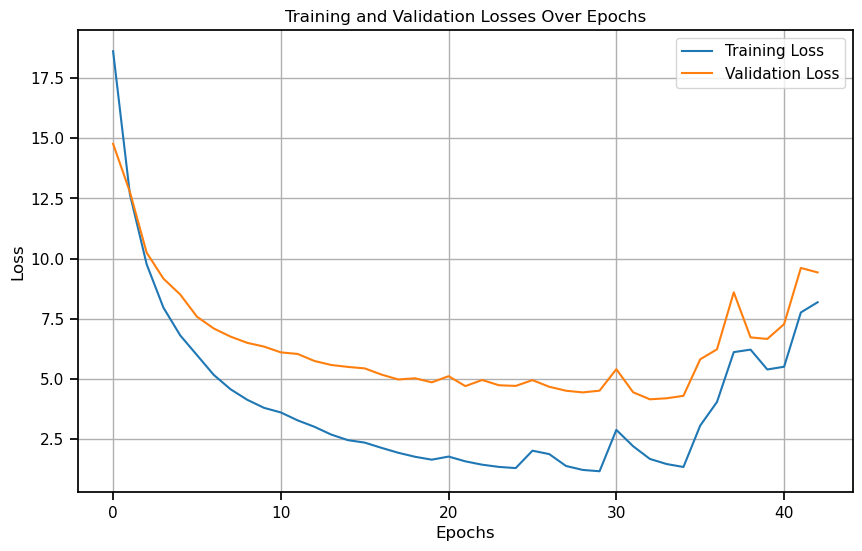

In [33]:
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(t_losses, val_losses)

In [34]:
def calc_explained_variance(x, y, weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        model = RNN_Main_Model(num_features= num_features, hnet_output = weights,  hidden_size = n_hidden_units,
                            num_layers= num_layers, out_dims=num_dim_output,  
                            dropout= dropout, LSTM_ = LSTM_).to(device)  

        # Forward pass to get predictions
        predictions = model(inputs)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        r2 = explained_variance_score(y_true_2D, y_pred_2D)

    return r2

In [35]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[xx_train_base, yy_train_base],
             [xx_val_base, yy_val_base],
             [xx_test_base, yy_test_base]]

data_force = [[xx_train_force, yy_train_force],
             [xx_val_force, yy_val_force],
             [xx_test_force, yy_test_force]]

In [36]:
for index, [x,y] in enumerate(data_base):
    r2 = calc_explained_variance(x, y, W_base)
    print('Explained variance score for ', subsets[index], ' is : ', r2)


Explained variance score for  Training  is :  0.9358438849449158
Explained variance score for  Validation  is :  0.8675511181354523
Explained variance score for  Test  is :  0.8655193746089935


In [37]:
for index, [x,y] in enumerate(data_force):
    r2 = calc_explained_variance(x, y, W_force)
    print('Explained variance score for ', subsets[index], ' is : ', r2)

Explained variance score for  Training  is :  0.9086236357688904
Explained variance score for  Validation  is :  0.8310559093952179
Explained variance score for  Test  is :  0.8234804272651672


In [38]:
model_base_hnet = RNN_Main_Model(num_features= num_features, hnet_output = W_base,  hidden_size = n_hidden_units,
                            num_layers= num_layers, out_dims=num_dim_output,  
                            dropout= dropout, LSTM_ = LSTM_).to(device)  

In [39]:
model_force_hnet = RNN_Main_Model(num_features= num_features, hnet_output = W_force,  hidden_size = n_hidden_units,
                            num_layers= num_layers, out_dims=num_dim_output,  
                            dropout= dropout, LSTM_ = LSTM_).to(device) 

In [40]:
exp_base = 'RNN_hnet_'+name+'_'+date+'_Baseline'
exp_force = 'RNN_hnet_'+name+'_'+date+'_Force'
path_base = os.path.join(path_to_models,exp_base)
path_force = os.path.join(path_to_models,exp_force)
if not os.path.exists(path_base):
    os.makedirs(path_base)
if not os.path.exists(path_force):
    os.makedirs(path_force)
path_base_fold = os.path.join(path_base,'fold_{}.pth'.format(fold))
path_force_fold = os.path.join(path_force,'fold_{}.pth'.format(fold))
torch.save(model_base_hnet, path_base_fold)
torch.save(model_force_hnet, path_force_fold)